This notebook deterministically simulates the Exclusive Infection, Replacement Infection, Superinfection, Full-Coinfection  Uni and Bi-directional conversion models over the same parameters as Spickanll (2013). The models are run for 150 years starting with a population of 998 susceptible people, 1 person infected with the ABS strain and 1 person infected with the ABR strain. For all the model, but for the superinfection and single-strain model, the equilibrium prevalence as derived through stable point analyses has also being plotted.

**Note** These simulation reveals that the x-axis range in many of Spicknall et al (2013) sub-figures relating model endemic equilibrium prevalence is misprinted (A-C of figure 1 from Spickanll (2013)). The range in the proportion of the population receiving an antibiotic ($\epsilon$) must be higher than 0.15 for these sub-figures.

In [1]:
# Import necesary packages:
import matplotlib.pyplot as plt
import os
import string
import pandas as pd
import seaborn as sns
import numpy as np
from tqdm import tqdm
# Import custom module
import SMB_Code_models_equilibria as models_equil

In [2]:
# Setting up time for model running until equilibria should be a acheived, population to run and parameters
years = 150
days = int(365*years)
time_range = np. linspace (0 ,days ,2)
N = 1e3
epsilon_steps = 0.25
default_param_values = {'N':N,'beta_W': 0.04 , 'beta_Z': 0.015,'gamma': 0.01,'gamma_T': 0.1}
epsilon_vals_as_percent = np. arange (0, 100+epsilon_steps, epsilon_steps)

In [3]:
# Empty List for dataframes to concatanate into a single dataframe
deterministic_sims = []

# Setup class colors for plotting later.
classes_to_plot = ['Susceptible', 'All Sensitive Infections', 'All Resistant Infections']
palette = ['tab:green', 'gold', 'tab:red']

In [4]:
# Function to run a model through
def run_model_for_epsilon_values(model, param_values, epsilon_vals_as_percent, time_range):
    """
    Run model with parameter values through a range of % people receiving treatment.
    Reutrns dataframe of results for the last day of time_range.
    """
    data_dict = {'% Receiving Treatment':[],
                 'Class':[],
                 'Individuals':[]
                 }
    state_index_dict = {state.ID: index for index, state in enumerate(model.state_list)}
    init_state = np.zeros(model.num_state)
    init_state[state_index_dict['S']] = int(param_values ['N']-2)
    init_state[state_index_dict['I_W']] = int(1)
    init_state[state_index_dict['I_Z']] = int(1)
    for percent in tqdm(epsilon_vals_as_percent, desc='% Receiving Treatment'):
        param_values['epsilon']=percent/100
        model.parameters = param_values
        model. initial_values = ( init_state , time_range[0])
    
        det_run = model. integrate (time_range[1:])
        all_infecteds = {'All Sensitive Infections': [],
                         'All Resistant Infections': []}
        for state, index  in state_index_dict.items():
            value = det_run[-1, index]
            data_dict['Individuals'].append(value)
            data_dict['Class'].append(state)
            data_dict['% Receiving Treatment'].append(percent)
            if state in ['I_W', 'I_WZ', 'I_WW']:
                all_infecteds['All Sensitive Infections'].append(value)
            if state in ['I_Z', 'I_WZ', 'I_ZZ']:
                all_infecteds['All Resistant Infections'].append(value)
        for state, to_sum in all_infecteds.items():
            value = np.sum(to_sum)
            data_dict['Individuals'].append(value)
            data_dict['Class'].append(state)
            data_dict['% Receiving Treatment'].append(percent)
    
    data_df = pd.DataFrame(data_dict)
    full_state_descriptions = {'S': 'Susceptible',
                               'I_W': 'Singly Infected Sensitive',
                               'I_Z': 'Singly Infected Resistant',
                               'I_WZ': 'Superinfected',
                               'I_WW': 'Double Infected Sensitive',
                               'I_ZZ': 'Double Infected Resistant'}
    data_df.Class.replace(full_state_descriptions, inplace=True)
    return data_df

In [5]:
# function for calculating equilria
def run_equilibria_func_for_epsilon_values(equilibria_func, param_values, epsilon_vals_as_percent):
    """
    Detemine stable equilibria for parameter values through a range of % people receiving treatment.
    Reutrns dataframe of results.
    """
    data_dict = {'% Receiving Treatment':[],
                 'Class':[],
                 'Individuals':[]
                 }

    for percent in tqdm(epsilon_vals_as_percent, desc='% Receiving Treatment'):
        param_values['epsilon']=percent/100
        prevs = equilibria_func(param_values)
        for state, value in prevs[0].items():
            data_dict['Individuals'].append(value)
            data_dict['Class'].append(state)
            data_dict['% Receiving Treatment'].append(percent)

    data_df = pd.DataFrame(data_dict)
    full_state_descriptions = {'S': 'Susceptible',
                               'I_W': 'All Sensitive Infections',
                               'I_Z': 'All Resistant Infections'}
    data_df.Class.replace(full_state_descriptions, inplace=True)
    data_df.Individuals = data_df.Individuals.astype(np.float)
    return data_df

# Figure 1 Finding the Equilibrium prevalences via deterministic simulation.

## Singly infected models.

### Figure 1a Exclusive Infection model Endemic Equiliruim

In [6]:
#Simulating the model
data = run_model_for_epsilon_values(model=models_equil.AMR_exclus_inf_intia(),
                                    param_values=default_param_values,
                                    epsilon_vals_as_percent=epsilon_vals_as_percent,
                                    time_range=time_range)
data['Model'] = 'Exclusive Infection'
deterministic_sims.append(data)

% Receiving Treatment: 100%|██████████| 401/401 [01:04<00:00,  6.25it/s]


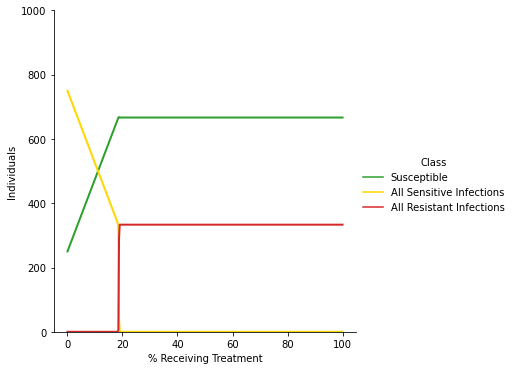

In [7]:
# Creating figure of simulation
fig = sns.relplot(
    data=data,
    x='% Receiving Treatment', y='Individuals',
    hue="Class", hue_order=classes_to_plot,
    kind="line", palette=palette, linewidth=2,
    aspect=1)
fig.set(ylim=(0,N))
plt.show()

In [8]:
# Determining endemic equilibia prevelance through stable point analyses.
data = run_equilibria_func_for_epsilon_values(equilibria_func=models_equil.exclus_inf_end_equil,
                                              param_values=default_param_values,
                                              epsilon_vals_as_percent=epsilon_vals_as_percent)

% Receiving Treatment: 100%|██████████| 401/401 [00:27<00:00, 14.51it/s]
<ipython-input-5-cd4d980ac256>:25: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  data_df.Individuals = data_df.Individuals.astype(np.float)


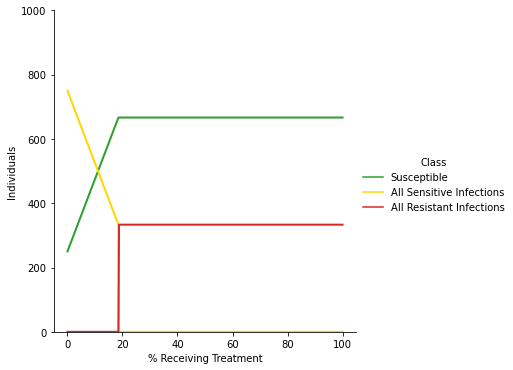

In [9]:
fig = sns.relplot(
    data=data,
    x='% Receiving Treatment', y='Individuals',
    hue="Class", hue_order=classes_to_plot,
    kind="line", palette=palette, linewidth=2,
    aspect=1)
fig.set(ylim=(0,N))
plt.show()

### Figure 1b Replacement Infection model Endemic Equiliruim

In [10]:
#Simulating the model
data = run_model_for_epsilon_values(model=models_equil.AMR_replace_inf_intia(),
                                    param_values=default_param_values,
                                    epsilon_vals_as_percent=epsilon_vals_as_percent,
                                    time_range=time_range)
data['Model'] = 'Replacement Infection'
deterministic_sims.append(data)

% Receiving Treatment: 100%|██████████| 401/401 [00:47<00:00,  8.46it/s]


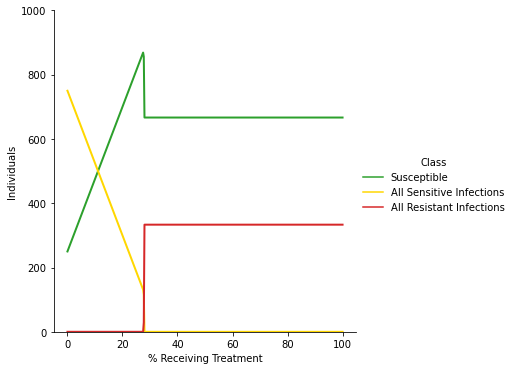

In [11]:
# Creating figure of simulation
fig = sns.relplot(
    data=data,
    x='% Receiving Treatment', y='Individuals',
    hue="Class", hue_order=classes_to_plot,
    kind="line", palette=palette, linewidth=2,
    aspect=1)
fig.set(ylim=(0,N))
plt.show()

In [12]:
# Determining endemic equilibia prevelance through stable point analyses.
data = run_equilibria_func_for_epsilon_values(equilibria_func=models_equil.replace_inf_end_equil,
                                              param_values=default_param_values,
                                              epsilon_vals_as_percent=epsilon_vals_as_percent)

% Receiving Treatment: 100%|██████████| 401/401 [00:29<00:00, 13.38it/s]
<ipython-input-5-cd4d980ac256>:25: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  data_df.Individuals = data_df.Individuals.astype(np.float)


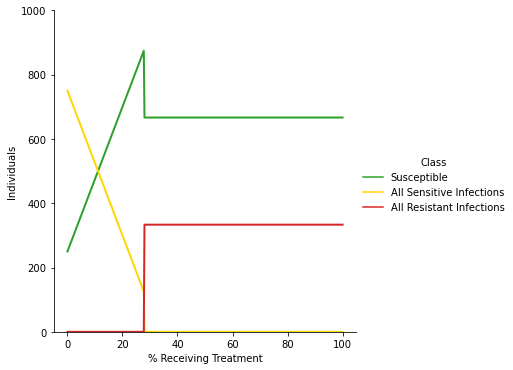

In [13]:
fig = sns.relplot(
    data=data,
    x='% Receiving Treatment', y='Individuals',
    hue="Class", hue_order=classes_to_plot,
    kind="line", palette=palette, linewidth=2,
    aspect=1)
fig.set(ylim=(0,N))
plt.show()

## Double Infection models.

### Figure 1c Superinfection model

**Note** The equilibria for this model has not been derived.

In [14]:
#Simulating the model
data = run_model_for_epsilon_values(model=models_equil.AMR_superinf_intia(),
                                    param_values={**default_param_values, 'q': 0.5},
                                    epsilon_vals_as_percent=epsilon_vals_as_percent,
                                    time_range=time_range)
data['Model'] = 'Superinfection'
deterministic_sims.append(data)

% Receiving Treatment: 100%|██████████| 401/401 [00:51<00:00,  7.80it/s]


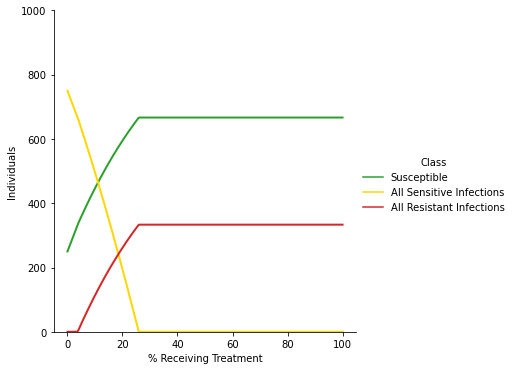

In [15]:
# Creating figure of simulation
fig = sns.relplot(
    data=data,
    x='% Receiving Treatment', y='Individuals',
    hue="Class", hue_order=classes_to_plot,
    kind="line", palette=palette, linewidth=2,
    aspect=1)
fig.set(ylim=(0,N))
plt.show()

### Figure 1d Full Coinfection model

In [16]:
#Simulating the model
data = run_model_for_epsilon_values(model=models_equil.AMR_full_co_inf_intia(),
                                    param_values={**default_param_values, 'q': 0.5},
                                    epsilon_vals_as_percent=epsilon_vals_as_percent,
                                    time_range=time_range)
data['Model'] = 'Full Coinfection'
deterministic_sims.append(data)

% Receiving Treatment: 100%|██████████| 401/401 [00:53<00:00,  7.52it/s]


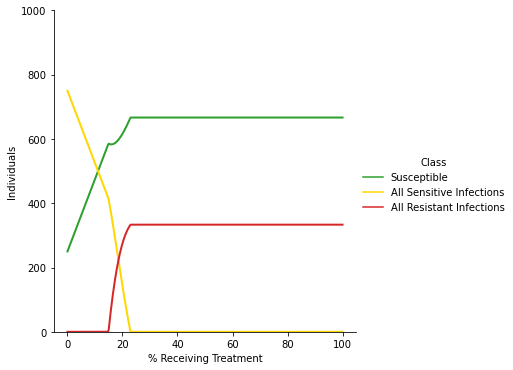

In [17]:
# Creating figure of simulation
fig = sns.relplot(
    data=data,
    x='% Receiving Treatment', y='Individuals',
    hue="Class", hue_order=classes_to_plot,
    kind="line", palette=palette, linewidth=2,
    aspect=1)
fig.set(ylim=(0,N))
plt.show()

## Conversion models

### Figure 1e Uni-direction Conversion model

In [18]:
#Simulating the model
data = run_model_for_epsilon_values(model=models_equil.AMR_bi_and_uni_conversion_inf_intia(),
                                    param_values={**default_param_values, 'rho':0.5,'phi':0},
                                    epsilon_vals_as_percent=epsilon_vals_as_percent,
                                    time_range=time_range)
data['Model'] = 'Unidirectional Conversion'
deterministic_sims.append(data)

% Receiving Treatment: 100%|██████████| 401/401 [00:49<00:00,  8.07it/s]


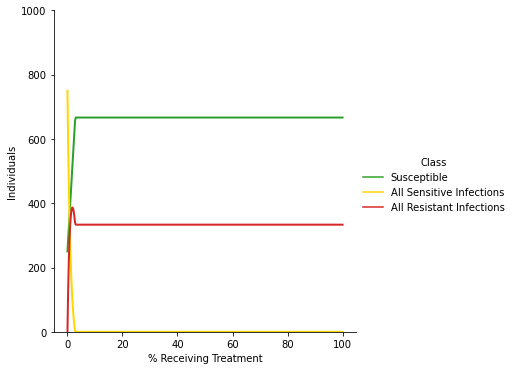

In [19]:
# Creating figure of simulation
fig = sns.relplot(
    data=data,
    x='% Receiving Treatment', y='Individuals',
    hue="Class", hue_order=classes_to_plot,
    kind="line", palette=palette, linewidth=2,
    aspect=1)
fig.set(ylim=(0,N))
plt.show()

In [20]:
# Determining endemic equilibria prevalence through stable point analyses.
data = run_equilibria_func_for_epsilon_values(equilibria_func=models_equil.bi_directional_end_equil,
                                              param_values={**default_param_values, 'rho':0.5,'phi':0},
                                              epsilon_vals_as_percent=epsilon_vals_as_percent)

% Receiving Treatment: 100%|██████████| 401/401 [10:07<00:00,  1.51s/it] 
<ipython-input-5-cd4d980ac256>:25: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  data_df.Individuals = data_df.Individuals.astype(np.float)


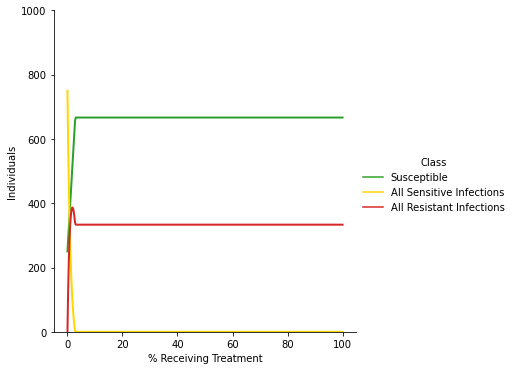

In [21]:
fig = sns.relplot(
    data=data,
    x='% Receiving Treatment', y='Individuals',
    hue="Class", hue_order=classes_to_plot,
    kind="line", palette=palette, linewidth=2,
    aspect=1)
fig.set(ylim=(0,N))
plt.show()

## Figure 1f Bi-direction Conversion model

In [22]:
#Simulating the model
data = run_model_for_epsilon_values(model=models_equil.AMR_bi_and_uni_conversion_inf_intia(),
                                    param_values={**default_param_values, 'rho':0.5,'phi':0.05},
                                    epsilon_vals_as_percent=epsilon_vals_as_percent,
                                    time_range=time_range)
data['Model'] = 'Bidirectional Conversion'
deterministic_sims.append(data)

% Receiving Treatment: 100%|██████████| 401/401 [00:50<00:00,  7.89it/s]


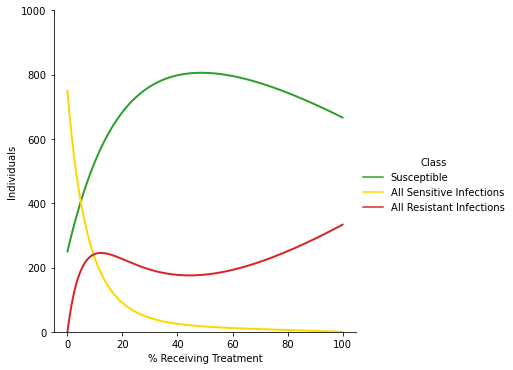

In [23]:
# Creating figure of simulation
fig = sns.relplot(
    data=data,
    x='% Receiving Treatment', y='Individuals',
    hue="Class", hue_order=classes_to_plot,
    kind="line", palette=palette, linewidth=2,
    aspect=1)
fig.set(ylim=(0,N))
plt.show()

In [24]:
# Determining endemic equilibria prevalence through stable point analyses.
data = run_equilibria_func_for_epsilon_values(equilibria_func=models_equil.bi_directional_end_equil,
                                              param_values={**default_param_values, 'rho':0.5,'phi':0.05},
                                              epsilon_vals_as_percent=epsilon_vals_as_percent)

% Receiving Treatment: 100%|██████████| 401/401 [05:38<00:00,  1.19it/s]
<ipython-input-5-cd4d980ac256>:25: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  data_df.Individuals = data_df.Individuals.astype(np.float)


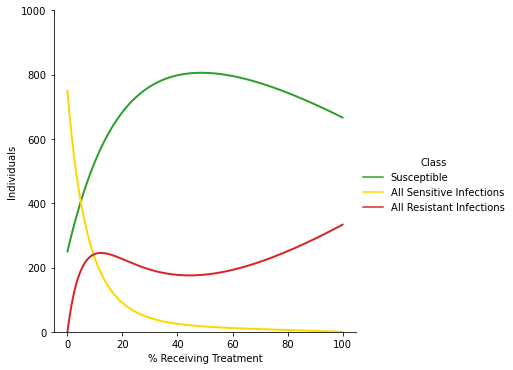

In [25]:
fig = sns.relplot(
    data=data,
    x='% Receiving Treatment', y='Individuals',
    hue="Class", hue_order=classes_to_plot,
    kind="line", palette=palette, linewidth=2,
    aspect=1)
fig.set(ylim=(0,N))
plt.show()

# Merging all simulations dataframes and creating a single figure.

In [26]:
full_data_df = pd.concat(deterministic_sims)
save_path = os.getcwd() # change to chosen directory.
full_data_df.to_csv(save_path+'/deterministic data.csv', index=False)

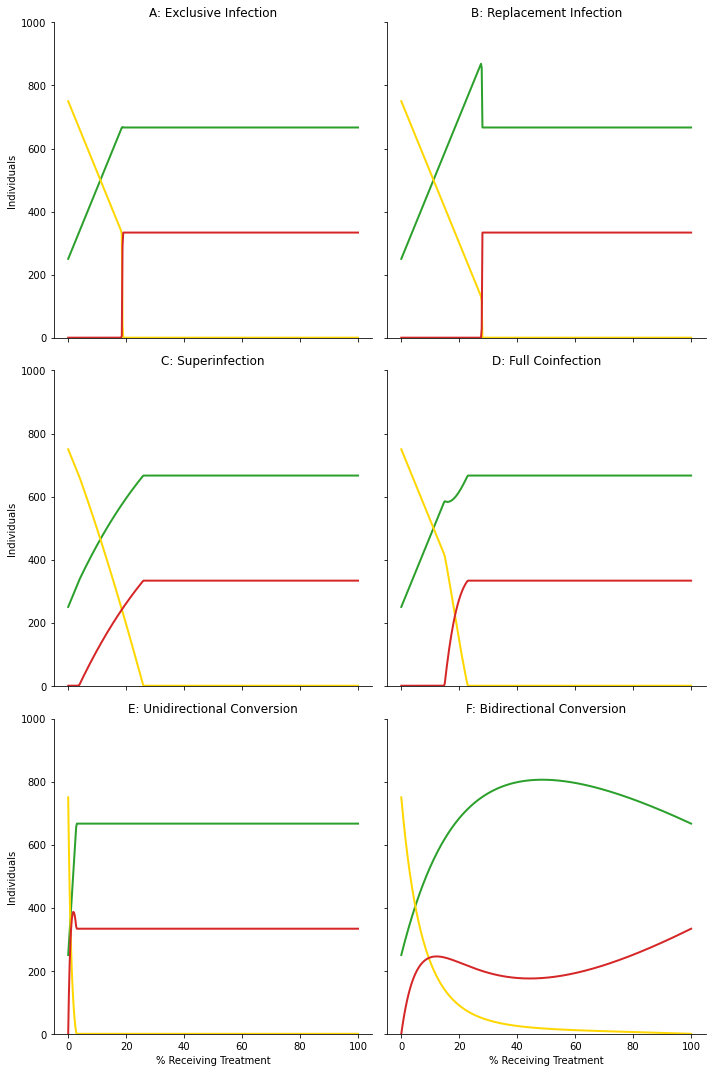

In [27]:
mod_order = ['Exclusive Infection', 'Replacement Infection',
             'Superinfection', 'Full Coinfection',
             'Unidirectional Conversion', 'Bidirectional Conversion']

fig = sns.relplot(
    data=full_data_df,
    x='% Receiving Treatment', y='Individuals',
    hue="Class", hue_order=classes_to_plot,
    col="Model", col_order=mod_order, col_wrap=2,
    kind="line", palette=palette,legend=False, linewidth=2,
    aspect=1)
# ADJUST ALL AXES TITLES
fig.set_titles('{col_name}')
alpha = list(string.ascii_uppercase)
axes = fig.axes.flatten()
for ax, letter in zip(axes, alpha[:len(axes)]):
    ttl = ax.get_title()   # GET CURRENT TITLE
    ax.set_title(f"{letter}: {ttl}")            # SET NEW TITLE

fig.set(ylim=(0,N))
plt.tight_layout()  # automatically adjust spacing of axes
plt.savefig('Deterministic Simulations.png')